# 일요일은 AI 
## HOML chapter 16
### BERT 실습

참고자료 : https://github.com/NLP-kr/tensorflow-ml-nlp-tf2?msclkid=a96ee29fc1f911ecb88e9368b34ab67d

# 버트를 활용한 한국어 기계독해  


   * 기계가 텍스트를 읽고 이해한 후 특정 질문에 대한 정확한 해답을 제시하는 것  
   * 한국어 기계독해 데이터 셋 KorQuAD 1.0 (LG CNS)

# 환경설정

In [1]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

#MAX_LEN = 384 # GPU 16기가
MAX_LEN = 200 # my gpu 6기가

EPOCHS = 3
VERBOSE = 2
#BATCH_SIZE = 16 # GPU 16기가
BATCH_SIZE = 10

In [2]:
DATA_OUT_PATH = './data_out/KOR'

In [3]:
def plot_graphs(history, string, string_1, string_2):
    # loss 
    plt.plot(history.history[string])
    plt.plot(history.history[string_1])
    plt.plot(history.history[string_2])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string_1, string_2])
    plt.show()

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

# 버트 다운로드

* 두가지 모듈 필요  
  토크나이저 - 데이터 전처리(모델을 학습할 때와 동일한 규칙으로 해야 한다.)  
  모델 - 가중치를 가지고 있다.

### 다국어 (102개 언어) 토크나이저 다운로드 - 한글 전처리를 위해

In [5]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)

In [6]:
save_path = "bert-base-multilingual-cased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

('bert-base-multilingual-cased/vocab.txt',
 'bert-base-multilingual-cased/special_tokens_map.json',
 'bert-base-multilingual-cased/added_tokens.json')

In [7]:
# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)

### KorQuAD 버전 1.0 데이터셋 다운로드

In [8]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

In [9]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased/')

'./bert-base-multilingual-cased//bert-base-multilingual-cased-config.json'

In [10]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')

In [11]:
# 1기가 파일, 20분 걸림. 따로 받을 것
#wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out='./bert-base-multilingual-cased/')

In [12]:
#os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')

# 전처리

In [13]:
class SquadExample:
    '''모델에 입력가능한 학습데이터로 변경'''
    def __init__(self, question, context, start_char_idx, answer_text):
        '''create_squad_exmples 함수를 통해 데이터를 1차 가공한 값을 할당
        '''
        self.question = question # 질문
        self.context = context # 본문
        self.start_char_idx = start_char_idx # 본문에서 시작위치
        self.answer_text = answer_text # 정답
        # 데이터를 사용할 지 사용하지 않을 지 결정하는 변수
        # Flalse : 학습, 평가 데이터로 사용
        # True : 사용안함.
        self.skip = False

    def preprocess(self):
        '''
        입력되는 문자열은 유니코드 형태로, 문제를 일으킬 수 있는 다양한 요소가 존재
        문자열 입력에 문제가 없도록 변경
        1. 문자열로 만든다.
        2. 스페이스 단위로 나눈다. 
        3. 나눈 값들어 다시 스페이스 단위로 바꾼다. (입력에 문제가 일어날 요소를 사전에 정리)
        4. 답이 본문 (Context) 에 존재하지 않으면 skip = True
        
        tockenizer.encoder로 토큰화되고, 인덱스로 변경되면서 시작 토큰의 위치와 끝 토큰을 다시 계산
        5. 본문(context) 길이만큼 0으로 채운다. 
        6. 답이 존재하는 부분을 1로 채운다.
        7. 본문(context)을 tokenizer.encode로 사전의 인덱스 값으로 변환한다. 
        8. 정답의 위치를 찾아서 ans_token_idx에 담는다.
        9. 답이 없는 경우 skip = True
        10. 정답의 시작, 끝 위치 저장
        11. 질문을 tokenizer.encode 한다. 
        12. 본문의 토큰 인덱스 + 질문의 토큰 인덱스를 연결한다. 
        13. 본문은 0 으로 질문은 1로, token_type_ids 를 만든다.
        14. 입력의 전체 길이를 1로 하는 attention_mask를 만든다.
        15. 최대 길이만큼 패드를 설정한다. 
        '''
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # 1, 2, 3  Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # 4. Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # 5. 6. Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # 7. Tokenize context
        tokenized_context = tokenizer.encode(context)

        # 8. Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        #9. 답이 없는 경우        
        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # 10. Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # 11. Tokenize question
        tokenized_question = tokenizer.encode(question)

        # 12. Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        # 13. token_type_ids 만들기
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        # 14. 어텐션 마스크 범위 설정
        attention_mask = [1] * len(input_ids)

        # 15. Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets

In [14]:
def create_squad_examples(raw_data):
    '''json 데이터 구조에서 모델 입력에 필요한 질문, 본문, 정답을 가져온다.
    '''
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"] # 본문
            for qa in para["qas"]:
                question = qa["question"] # 질문
                answer_text = qa["answers"][0]["text"] # 정답
                start_char_idx = qa["answers"][0]["answer_start"] # 본문에서 정답의 위치 포지션
                # 모델에 입력가능한 학습 데이터로 변경한다.
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text
                )
                
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples

In [15]:
def create_inputs_targets(squad_examples):
    '''훈련, 평가에 사용될 입력값과 정답을 만든다.'''
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    # sqad_eg 객체의 속성값을 딕션어리 dataset_dict로 변환
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    # list를 numpy array로 바꾼다.             
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    # 입력값 x
    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    # 정답 y
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [16]:
with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)

In [17]:
# json 피일을 넣어서, train_squad_examples 를 만든다. 
train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

60407 training points created.
5774 evaluation points created.


### 데이터를 까보자.

In [18]:
import pprint
pprint.pprint(raw_train_data['data'][0])

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 '
                            '하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 '
                            '산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
                            '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 '
                            '베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 '
                            '서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. '
                            '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 '
                            '반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 '
                            '교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 '
                            '중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 '
                            '연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 '
                            '지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. '
                            '그 사이에 그는 리엔치와 방황하는 네덜란

In [19]:
# 본문
c1 = raw_train_data['data'][0]['paragraphs'][0]['context']
print(len(c1))
c1

673


'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'

In [20]:
# 질문
q1 = raw_train_data['data'][0]['paragraphs'][0]['qas'][0]['question']
q1

'바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'

In [21]:
# 정답
a1 = raw_train_data['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
a1

'교향곡'

In [22]:
# 정답 시작 위치
a1p = raw_train_data['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
a1p

54

In [23]:
#BERT의 token 으로 변환
','.join(tokenizer.encode(q1,add_special_tokens=True).tokens)

'[CLS],바,##그,##너,##는,괴,##테,##의,파,##우스,##트를,읽,##고,무,##엇,##을,쓰,##고,##자,했,##는,##가,?,[SEP]'

In [24]:
tokenizer.encode('나는 학교에 간다',add_special_tokens=True)

Encoding(num_tokens=8, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [25]:
print('tokens', tokenizer.encode('나는 학교에 간다',add_special_tokens=True).tokens)
print('ids', tokenizer.encode('나는 학교에 간다',add_special_tokens=True).ids)
print('offsets', tokenizer.encode('나는 학교에 간다',add_special_tokens=True).offsets)
print('attention_mask', tokenizer.encode('나는 학교에 간다',add_special_tokens=True).attention_mask)

tokens ['[CLS]', '나는', '학', '##교', '##에', '간', '##다', '[SEP]']
ids [101, 100585, 9953, 25242, 10530, 8845, 11903, 102]
offsets [(0, 0), (0, 2), (3, 4), (4, 5), (5, 6), (7, 8), (8, 9), (0, 0)]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1]


In [62]:
train_squad_examples[0]

In [27]:
# valid 건수
tot_cnt = 0
valid_cnt = 0
valid_idx = []
for item in train_squad_examples:
    tot_cnt = tot_cnt + 1
    if item.skip == False:
        valid_cnt = valid_cnt+1
        valid_idx.append(tot_cnt)
print (tot_cnt, valid_cnt)
print(valid_idx[:5])

60407 228
[852, 853, 854, 855, 856]


In [28]:
VIDX = valid_idx[0]
print('input_ids:')
print(','.join([str(id) for id in train_squad_examples[VIDX].input_ids]))
print('token_type_ids:')
print(','.join([str(id) for id in train_squad_examples[VIDX].token_type_ids]))
print('attention_mask:')
print(','.join([str(id) for id in train_squad_examples[VIDX].attention_mask]))
print('start_token_idx:')
print(train_squad_examples[VIDX].start_token_idx)
print('end_token_idx:')
print(train_squad_examples[VIDX].end_token_idx)

input_ids:
101,9238,60469,15001,9477,22695,21039,8885,113,12852,11118,39923,13005,117,29653,11259,117,10888,10954,16743,46659,198,114,9632,9245,11664,9477,22695,113,72883,46817,114,9202,110335,99533,9113,30873,118920,117,108399,117,76512,11287,117,84703,11903,119,9379,119373,24891,10459,9113,30873,118920,11261,9996,18778,14523,32613,15387,9625,16758,24982,11513,9999,118813,12490,119,9069,21789,9954,9634,30134,10459,9954,8889,11489,9238,15001,9356,84372,11261,9735,29935,38181,117,8924,81724,11018,1886,12613,169,12936,49983,10188,11590,23113,1887,117,1886,30129,24358,67091,1887,117,1886,13073,12703,1887,117,8924,20173,9798,41605,11102,1886,13968,13817,10454,1887,36322,11506,119,9379,119373,24891,99706,1886,11740,112,188,30598,11589,12716,1887,117,1886,45442,46740,112,187,17590,1887,9233,9506,11664,117,1886,12489,35720,10576,1887,8898,1886,27633,1887,77547,37321,8896,18778,76512,11287,11261,8932,31398,13628,119,102,99533,9113,30873,118920,117,108399,117,76512,11287,117,84703,11261,8932,12

### 훈련 데이터 엿보기 (BERT token -> 한글)

In [29]:
train_squad_examples[VIDX].context

"리처드 스타키 경(Sir Richard Starkey, MBE, 1940년 7월 7일 ~ )은 링고 스타(Ringo Starr)로 알려진 영국의 드러머, 가수, 작곡가, 배우다. 비틀즈의 드러머로 활동해 세계적인 유명세를 획득했다. 대개 한 음반의 한 곡에서 리드 보컬로 참여했고, 그중에는 〈With a Little Help from My Friends〉, 〈Yellow Submarine〉, 〈Good Night〉, 그들이 커버한 〈Act Naturally〉 등이 있다. 비틀즈 노래 〈Don't Pass Me By〉, 〈Octopus's Garden〉를 썼고, 〈What Goes On〉과 〈Flying〉 등에서는 공동 작곡가로 기록되었다."

In [30]:
tokenizer.decode(train_squad_examples[VIDX].input_ids)

"리처드 스타키 경 ( Sir Richard Starkey, MBE, 1940년 7월 7일 ~ ) 은 링고 스타 ( Ringo Starr ) 로 알려진 영국의 드러머, 가수, 작곡가, 배우다. 비틀즈의 드러머로 활동해 세계적인 유명세를 획득했다. 대개 한 음반의 한 곡에서 리드 보컬로 참여했고, 그중에는 〈 With a Little Help from My Friends 〉, 〈 Yellow Submarine 〉, 〈 Good Night 〉, 그들이 커버한 〈 Act Naturally 〉 등이 있다. 비틀즈 노래 〈 Don't Pass Me By 〉, 〈 Octopus's Garden 〉 를 썼고, 〈 What Goes On 〉 과 〈 Flying 〉 등에서는 공동 작곡가로 기록되었다. 영국의 드러머, 가수, 작곡가, 배우로 기사 작위를 받은 링고 스타의 본명은?"

In [31]:
SIDX = train_squad_examples[VIDX].start_token_idx
EIDX = train_squad_examples[VIDX].end_token_idx
tokenizer.decode(train_squad_examples[VIDX].input_ids[SIDX:EIDX+1])

'리처드 스타키'

# 모델 정의

In [32]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBERTQuestionAnswering, self).__init__()
        
        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
        self.flatten = tf.keras.layers.Flatten() 
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)
        
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)
        
        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)
        
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)
    
        return start_probs, end_probs

In [33]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/',dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Some weights of the model checkpoint at ./bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at ./bert-base-multilingual-cased/.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


# 후처리  
- 평가 점수에 영향을 줄 수 있는 특수기호 제거

In [34]:
def normalized_answer(s):   
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text) 
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)   
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)      
        return text

    def white_space_fix(text):
        '''나뉜 문자를 공객으로 연결해서 결괏값으로 넘겨준다.'''
        return ' '.join(text.split())

    def remove_punc(text):
        ''' 구두점 삭제 '''
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        ''' 소문자로 통일'''
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

### 평가지표  
   - 정확 매칭 (Exact Matching)
     정답 : 자연어 처리  
     예측 :  
            자연어 처 (X)  
            자연어 처리의 (X)  
            자연어 처리 (O)

In [35]:
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        '''평가에 사용될 데이터를 받는다. 
           x_eval : 본문과 질문이 결합된 데이터
           y_eval : 정답
        '''
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        '''예측한 값과 정답을 비교한다. 
        '''
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        # skip == Flase : 정답이 본문에 포함돼 있음을 의미
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = normalized_answer(squad_eg.answer_text)
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [36]:
exact_match_callback = ExactMatch(x_eval,y_eval)

In [37]:
# 시작 토큰에 대한 손실, 마지막 토큰에 대한 손실
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [38]:
model_name = "tf2_bert_korquad"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
# 가장좋은모델만 저장, 가중치만 저장
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

./data_out/KOR/tf2_bert_korquad -- Folder already exists 



In [63]:
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback, cp_callback] # 평가함수, 모델저장
)

Epoch 1/3

epoch=1, exact match score=0.65
23/23 - 10s - loss: 0.4969 - output_1_loss: 0.1806 - output_2_loss: 0.3163
Epoch 2/3

epoch=2, exact match score=0.74
23/23 - 10s - loss: 0.4230 - output_1_loss: 0.1197 - output_2_loss: 0.3033
Epoch 3/3

epoch=3, exact match score=0.57
23/23 - 10s - loss: 0.3742 - output_1_loss: 0.1429 - output_2_loss: 0.2312


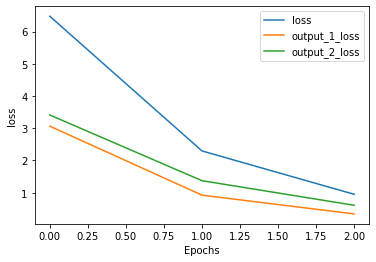

In [40]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')

# 예측

In [67]:
# 저장된 모델을 읽어 들인다.
# korquad_model = modelstf.keras.load_model(checkpoint_path)

* 본문

'빅뱅은 2006년 8월 19일 첫 싱글 〈 Bigbang 〉 을 발표하였고, 같은 날 YG 패밀리 10주년 콘서트에서 첫 무대에 섰다. 2006년 9월 23일 음악 프로그램 《 쇼! 음악중심 》 에서 공식 데뷔하였다. 승리는 그해 12월에 발매 된 빅뱅의 첫 번째 정규 음반 《 BIGBANG Vol. 1 》 에 수록 된 " 다음 날 " 로 첫 솔로 곡을 불렀다. 빅뱅은 2007년 그들의 첫 번째 EP 《 Always 》 의 발매와 동시에 타이틀 곡 " 거짓말 " 은 엄청난 메가히트를 기록했고, 이후 두 번째 EP 《 Hot Issue 》 의 " 마지막 인사 " 와 세 번째 EP 《 Stand Up 》 의 " 하루하루 " 가 연이어 차트 정상을 차지하며 최정상의 대세 그룹으로 우뚝 섰다.  

* 질문  
빅뱅에 데뷔 일자는?'

In [70]:
context = '''빅뱅은 2006년 8월 19일 첫 싱글 〈 Bigbang 〉 을 발표하였고, 같은 날 YG 패밀리 10주년 콘서트에서 첫 무대에 섰다. 2006년 9월 23일 음악 프로그램 《 쇼! 음악중심 》 에서 공식 데뷔하였다. 승리는 그해 12월에 발매 된 빅뱅의 첫 번째 정규 음반 《 BIGBANG Vol. 1 》 에 수록 된 " 다음 날 " 로 첫 솔로 곡을 불렀다. 빅뱅은 2007년 그들의 첫 번째 EP 《 Always 》 의 발매와 동시에 타이틀 곡 " 거짓말 " 은 엄청난 메가히트를 기록했고, 이후 두 번째 EP 《 Hot Issue 》 의 " 마지막 인사 " 와 세 번째 EP 《 Stand Up 》 의 " 하루하루 " 가 연이어 차트 정상을 차지하며 최정상의 대세 그룹으로 우뚝 섰다.'''
question = '''빅뱅에 데뷔 일자는?'''

context, quesion 을 모델의 입력값 형태로 만든다.

입력값 x

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]

In [71]:
context = " ".join(str(context).split())
question = " ".join(str(question).split())

In [102]:
tokenized_context = tokenizer.encode(context)
tokenized_question = tokenizer.encode(question)

input_ids = tokenized_context.ids + tokenized_question.ids[1:]
token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:])
attention_mask = [1] * len(input_ids)
padding_length = MAX_LEN - len(input_ids)
if padding_length > 0:  # pad
    input_ids = input_ids + ([0] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([0] * padding_length)
elif padding_length < 0:  # skip
    print('최대길이를 초과하였습니다.')

In [104]:
dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
dataset_dict['input_ids'].append(input_ids)
dataset_dict['token_type_ids'].append(token_type_ids)
dataset_dict['attention_mask'].append(attention_mask)

# list를 numpy array로 바꾼다.             
for key in dataset_dict:
    dataset_dict[key] = np.array(dataset_dict[key])

# 입력값 x
x = [
    dataset_dict["input_ids"],
    dataset_dict["token_type_ids"],
    dataset_dict["attention_mask"],
]

In [113]:
# prediction -> 200 차원의 소프트맥스 결과 벡터가 리턴된다. (원핫인코딩)
pred_start, pred_end = korquad_model.predict(x)

In [114]:
# 소프트맥스 결과에서 가장 큰 인덱스
pred_start = np.argmax(pred_start)
pred_end = np.argmax(pred_end)

In [115]:
# 예측 답 : 시작 인덱스, 종료 인덱스
print(pred_start, pred_end)

38 40


In [116]:
tokenizer.decode(input_ids[pred_start:pred_end+1])

'2006년 9월 23일'